In [72]:
pip install pykalman

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [74]:
df = pd.read_csv('sensor_data.csv')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13248 entries, 0 to 13247
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          13248 non-null  object 
 1   flowmeter_1  13236 non-null  float64
 2   flowmeter_2  13247 non-null  float64
 3   pressure_3   13248 non-null  float64
 4   flowmeter_4  13247 non-null  float64
 5   flowmeter_5  13239 non-null  float64
 6   flowmeter_6  13248 non-null  float64
 7   flowmeter_7  13247 non-null  float64
dtypes: float64(7), object(1)
memory usage: 828.1+ KB


In [76]:
# Number of NaNs per column
null_counts = df.isna().sum()

# Number of Zeros per column
zero_counts = (df == 0).sum()

# Combine both into a single DataFrame
summary = pd.DataFrame({
    'Null Values': null_counts,
    'Zero Values': zero_counts
})


In [77]:
print(summary)

             Null Values  Zero Values
_id                    0            0
flowmeter_1           12          815
flowmeter_2            1            0
pressure_3             0            1
flowmeter_4            1            0
flowmeter_5            9         3849
flowmeter_6            0            0
flowmeter_7            1            0


In [78]:
# Convert the '_id' column to datetime format
df['_id'] = pd.to_datetime(df['_id'])

# Set '_id' as the index
df.set_index('_id', inplace=True)

# Optional: sort the DataFrame by datetime index (recommended for time series)
df.sort_index(inplace=True)


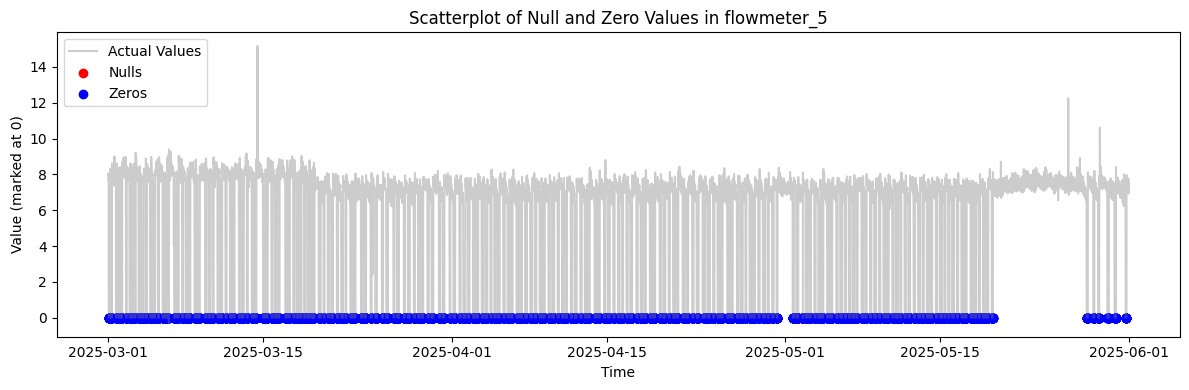

In [79]:
feature = 'flowmeter_5'

# Create a boolean mask for nulls and zeros
null_mask = df[feature].isna()
zero_mask = df[feature] == 0

plt.figure(figsize=(12, 4))

# Plot full feature as a line
plt.plot(df.index, df[feature], label='Actual Values', color='gray', alpha=0.4)

# Scatter plot for NaN values
plt.scatter(df.index[null_mask], [0]*null_mask.sum(), color='red', label='Nulls')

# Scatter plot for Zero values
plt.scatter(df.index[zero_mask], [0]*zero_mask.sum(), color='blue', label='Zeros')

plt.title(f"Scatterplot of Null and Zero Values in {feature}")
plt.xlabel("Time")
plt.ylabel("Value (marked at 0)")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-80-4165162496.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


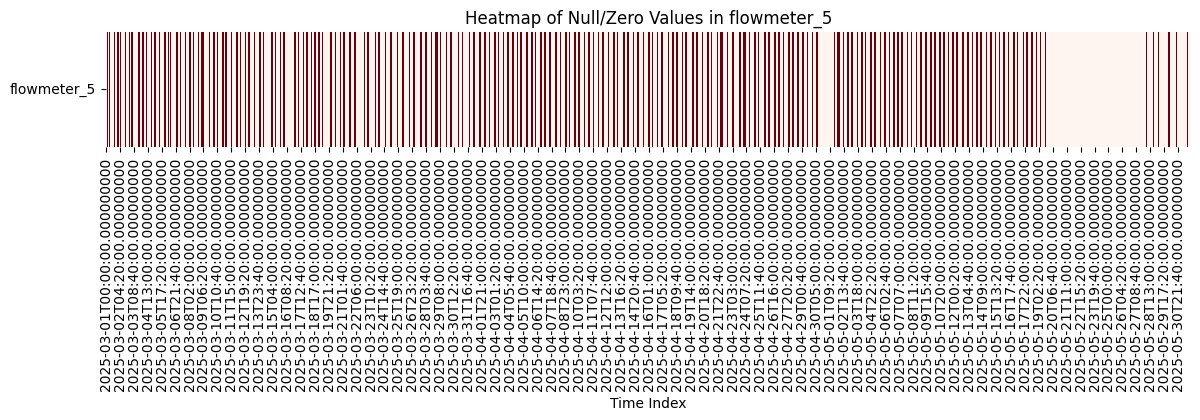

In [80]:
feature = 'flowmeter_5'

# Create a binary mask: 1 where null or zero, 0 otherwise
mask = df[feature].isna() | (df[feature] == 0)
binary_mask = mask.astype(int).to_frame(name=feature)

# Plot the heatmap
plt.figure(figsize=(14, 1.5))
sns.heatmap(binary_mask.T, cmap='Reds', cbar=False)

plt.title(f"Heatmap of Null/Zero Values in {feature}")
plt.xlabel("Time Index")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


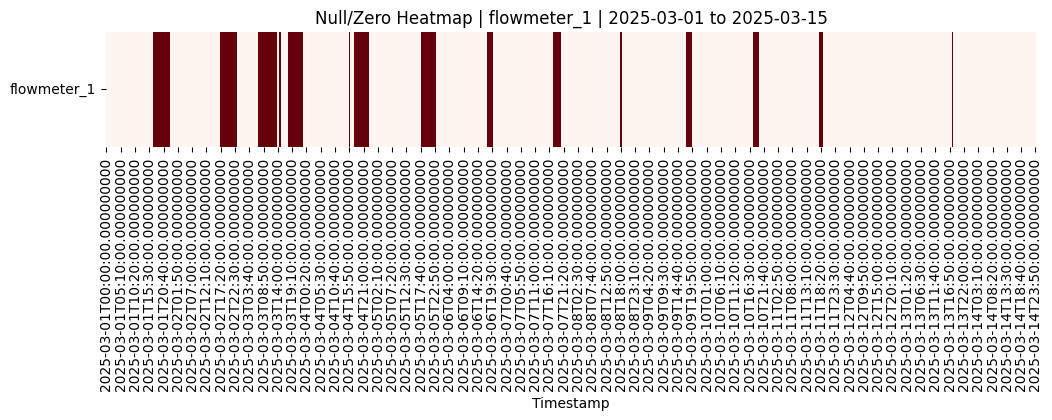

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


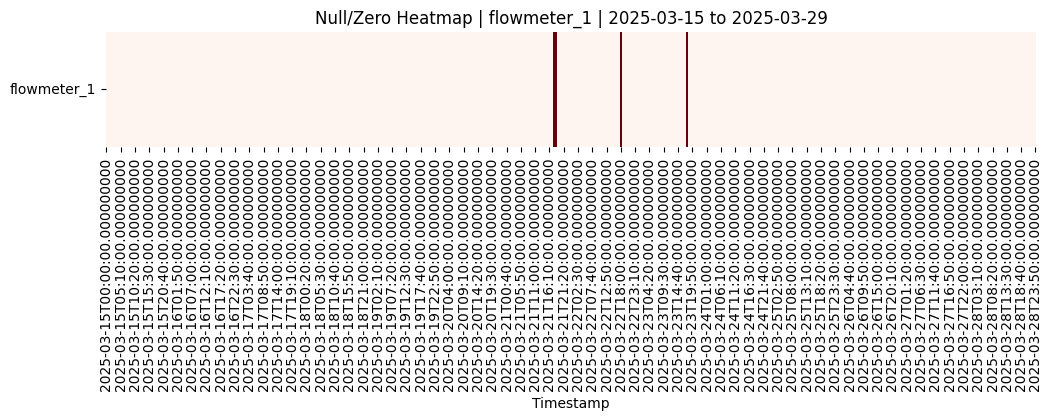

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


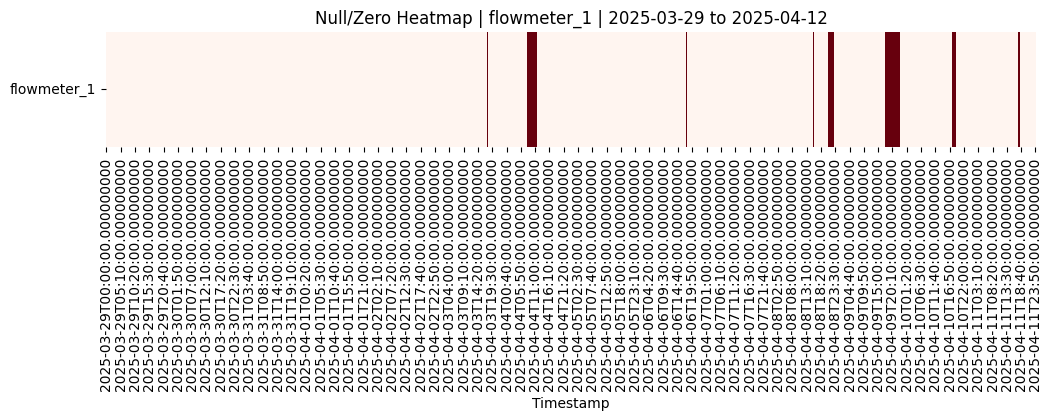

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


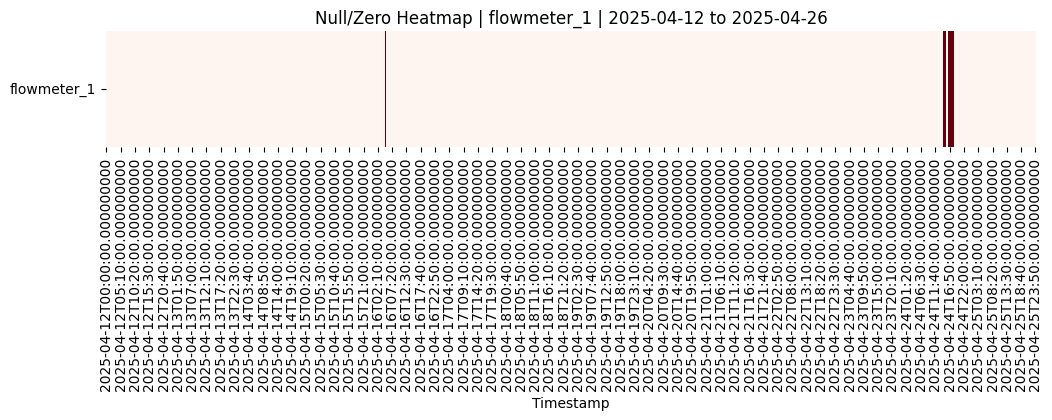

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


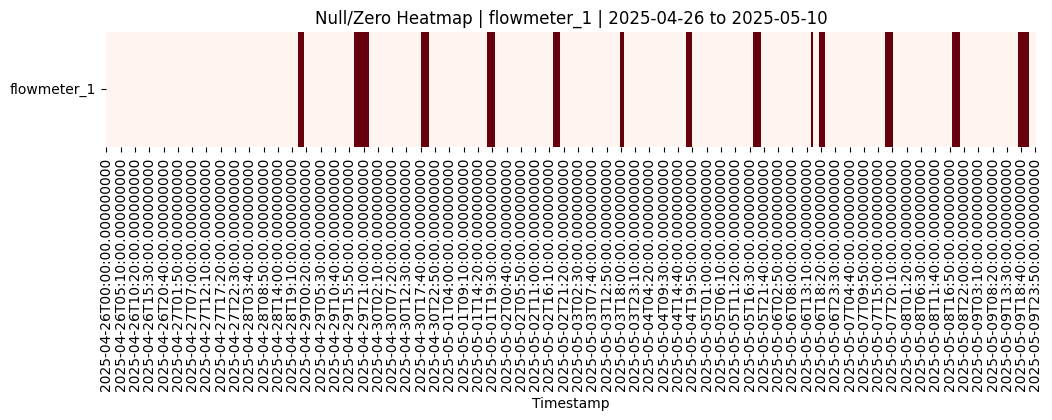

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


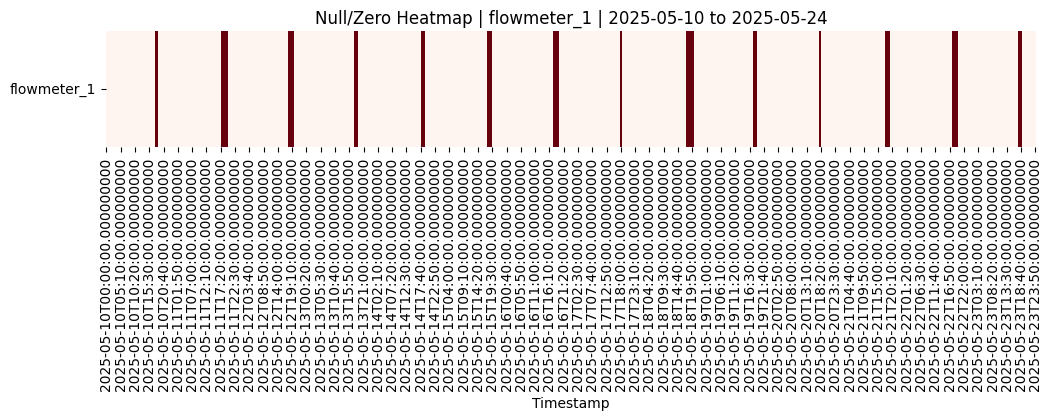

/tmp/ipython-input-81-252377825.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


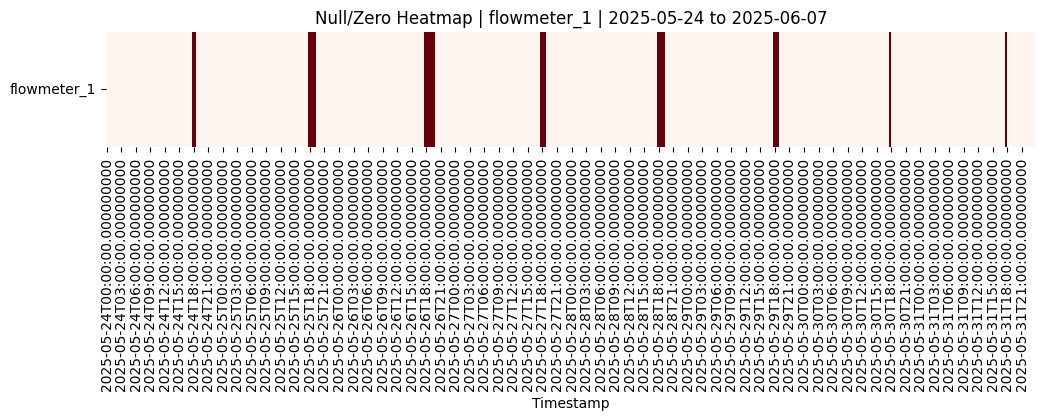

In [81]:
# Select the feature
feature = 'flowmeter_1'  # Replace as needed

# Create binary mask: 1 where value is NaN or 0, 0 otherwise
binary_mask = ((df[feature].isna()) | (df[feature] == 0)).astype(int).to_frame(name=feature)

# Get min and max datetime from the index
start_date = df.index.min()
end_date = df.index.max()

# Manually define biweekly ranges
current_start = start_date

while current_start < end_date:
    current_end = current_start + pd.Timedelta(weeks=2)

    # Slice the binary mask for current biweekly period
    chunk = binary_mask.loc[current_start:current_end]

    if not chunk.empty:
        # Plot heatmap
        plt.figure(figsize=(12, 1.5))
        sns.heatmap(chunk.T, cmap='Reds', cbar=False)
        plt.title(f"Null/Zero Heatmap | {feature} | {current_start.date()} to {current_end.date()}")
        plt.xlabel("Timestamp")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    # Move to next period
    current_start = current_end


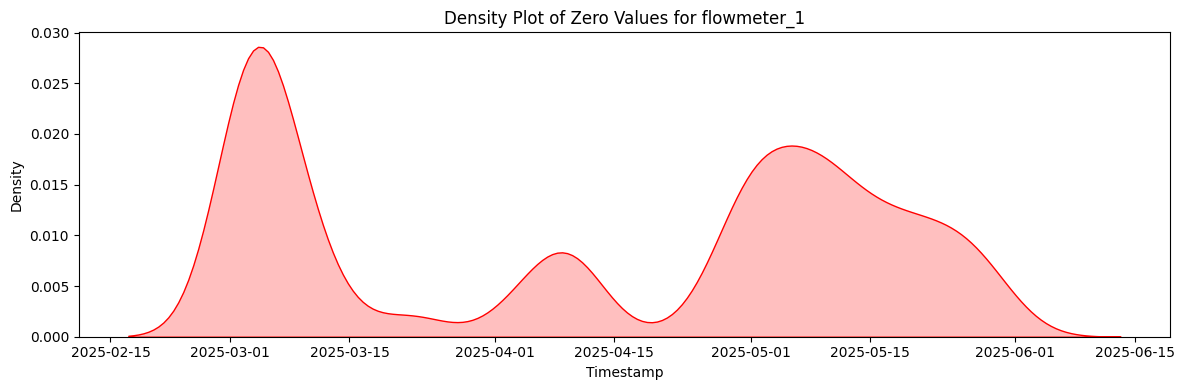

In [82]:
# Feature to analyze
feature = 'flowmeter_1'  # Replace with your column

# Filter timestamps where the value is exactly zero
zero_timestamps = df[df[feature] == 0].index

# Plot density of timestamps
plt.figure(figsize=(12, 4))
sns.kdeplot(pd.to_datetime(zero_timestamps), bw_adjust=0.5, fill=True, color='red')
plt.title(f"Density Plot of Zero Values for {feature}")
plt.xlabel("Timestamp")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


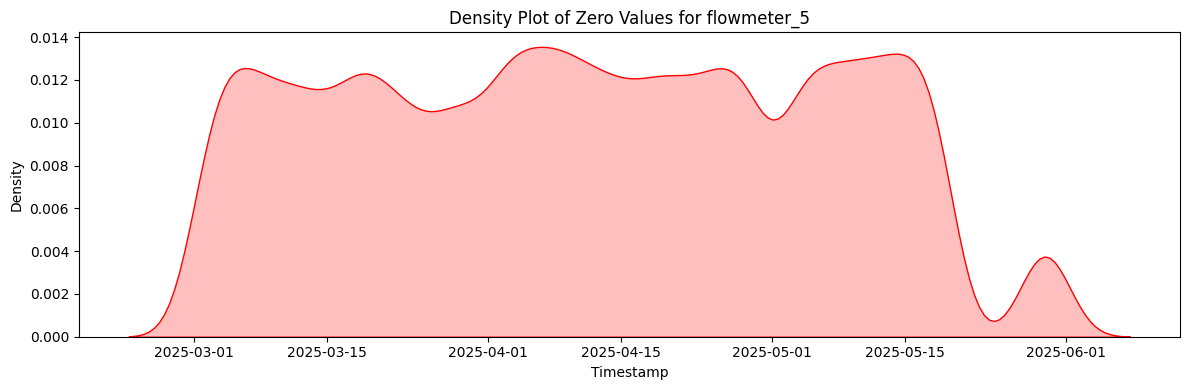

In [83]:
# Feature to analyze
feature = 'flowmeter_5'  # Replace with your column

# Filter timestamps where the value is exactly zero
zero_timestamps = df[df[feature] == 0].index

# Plot density of timestamps
plt.figure(figsize=(12, 4))
sns.kdeplot(pd.to_datetime(zero_timestamps), bw_adjust=0.5, fill=True, color='red')
plt.title(f"Density Plot of Zero Values for {feature}")
plt.xlabel("Timestamp")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [84]:
df = df.replace(0, np.nan)

In [85]:
cols = ['flowmeter_2', 'flowmeter_4','flowmeter_5', 'flowmeter_7']

for col in cols:
    vals = df[col].values
    vals_masked = np.ma.masked_invalid(vals)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=np.nanmean(vals),
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )
    kf = kf.em(vals_masked, n_iter=5)
    smoothed_state_means, _ = kf.smooth(vals_masked)
    kalman_1d = smoothed_state_means.flatten()

    # Copy original values
    filled = vals.copy()
    nan_mask = np.isnan(vals)
    filled[nan_mask] = kalman_1d[nan_mask]

    # Assign imputed values to a new column
    df[f'{col}_imputed'] = filled


In [86]:
pressure = ['pressure_3']

for col in pressure:
    vals = df[col].values
    vals_masked = np.ma.masked_invalid(vals)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=np.nanmean(vals),
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )
    kf = kf.em(vals_masked, n_iter=5)
    smoothed_state_means, _ = kf.smooth(vals_masked)
    kalman_1d = smoothed_state_means.flatten()

    # Copy original values
    filled = vals.copy()
    nan_mask = np.isnan(vals)
    filled[nan_mask] = kalman_1d[nan_mask]

    # Assign imputed values to a new column
    df[f'{col}_imputed'] = filled


In [87]:
# Ensure your DataFrame has 'flowmeter_1' and 'pressure'
obs = df[['flowmeter_1', 'pressure_3']].values
# Mask missing values (pykalman handles these naturally)
obs_masked = np.ma.masked_invalid(obs)


In [88]:

kf = KalmanFilter(
    n_dim_obs=2,
    n_dim_state=2,
    initial_state_mean=np.nanmean(obs, axis=0),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),           # Adjust if you have a process model
    observation_matrices=np.eye(2),
    observation_covariance=np.eye(2),        # Estimate or set based on data
    transition_covariance=0.01 * np.eye(2)   # Small process noise
)


In [89]:
# Fit parameters using Expectation-Maximization (EM), helpful with missing data
kf = kf.em(obs_masked, n_iter=10)

# Apply smoothing to estimate all positions, including missing values
state_means, _ = kf.smooth(obs_masked)


In [90]:
imputed = df['flowmeter_1'].copy()
missing_mask = df['flowmeter_1'].isna()
imputed[missing_mask] = state_means[missing_mask, 0]  # 0th column corresponds to flowmeter_1

df['flowmeter_1_imputed'] = imputed


In [91]:
# Create mask flags: True if original was NaN (i.e., imputed)
df['flowmeter_1_missing_flag'] = df['flowmeter_1'].isna()
df['flowmeter_5_missing_flag'] = df['flowmeter_5'].isna()

In [92]:
df['flowmeter_1_missing_flag'] = df['flowmeter_1_missing_flag'].astype(int)
df['flowmeter_5_missing_flag'] = df['flowmeter_5_missing_flag'].astype(int)


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flowmeter_1               12421 non-null  float64
 1   flowmeter_2               13247 non-null  float64
 2   pressure_3                13247 non-null  float64
 3   flowmeter_4               13247 non-null  float64
 4   flowmeter_5               9390 non-null   float64
 5   flowmeter_6               13248 non-null  float64
 6   flowmeter_7               13247 non-null  float64
 7   flowmeter_2_imputed       13248 non-null  float64
 8   flowmeter_4_imputed       13248 non-null  float64
 9   flowmeter_5_imputed       13248 non-null  float64
 10  flowmeter_7_imputed       13248 non-null  float64
 11  pressure_3_imputed        13248 non-null  float64
 12  flowmeter_1_imputed       13248 non-null  float64
 13  flowmeter_1_missing_flag  

In [94]:
# This will select only columns with no nulls (completely filled columns)
df_updated = df.loc[:, df.notnull().all()]

# The DateTimeIndex (your time index) remains unchanged,
# and you'll keep only the columns where ALL values are non-null

print(df_updated.shape)


(13248, 9)


In [95]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flowmeter_6               13248 non-null  float64
 1   flowmeter_2_imputed       13248 non-null  float64
 2   flowmeter_4_imputed       13248 non-null  float64
 3   flowmeter_5_imputed       13248 non-null  float64
 4   flowmeter_7_imputed       13248 non-null  float64
 5   pressure_3_imputed        13248 non-null  float64
 6   flowmeter_1_imputed       13248 non-null  float64
 7   flowmeter_1_missing_flag  13248 non-null  int64  
 8   flowmeter_5_missing_flag  13248 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.5 MB


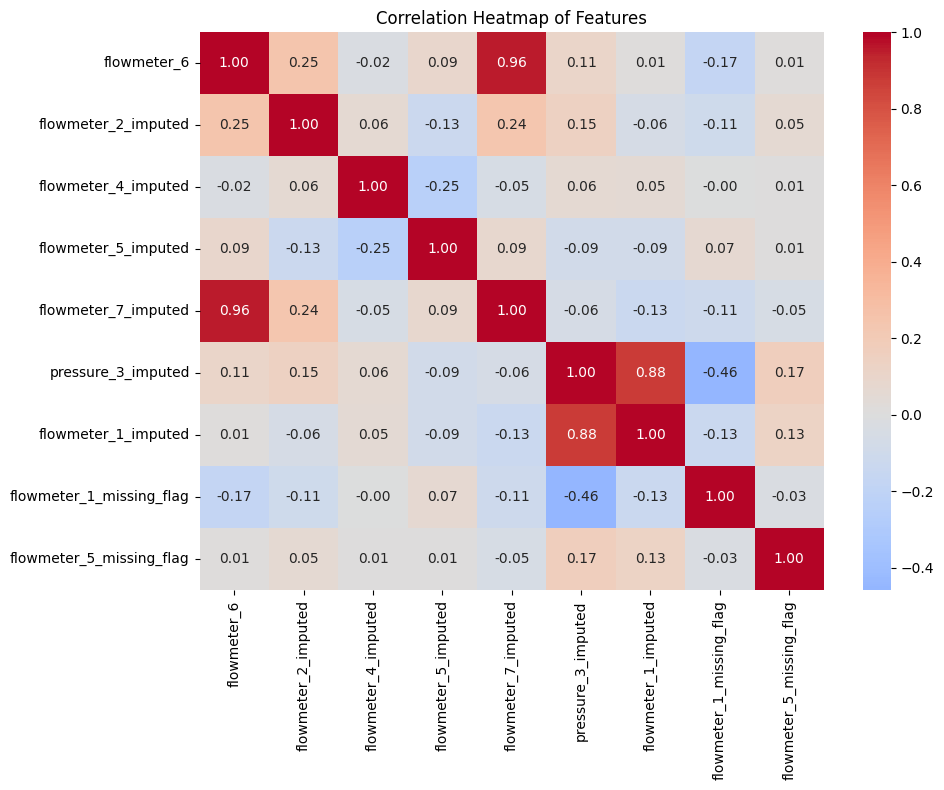

In [96]:
# Step 1: Select numeric features and clean
df_corr = df_updated.select_dtypes(include='number').copy()
df_corr = df_corr.replace([np.inf, -np.inf], np.nan).dropna()

# Step 2: Compute correlation matrix
corr_matrix = df_corr.corr()

# Step 3: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()


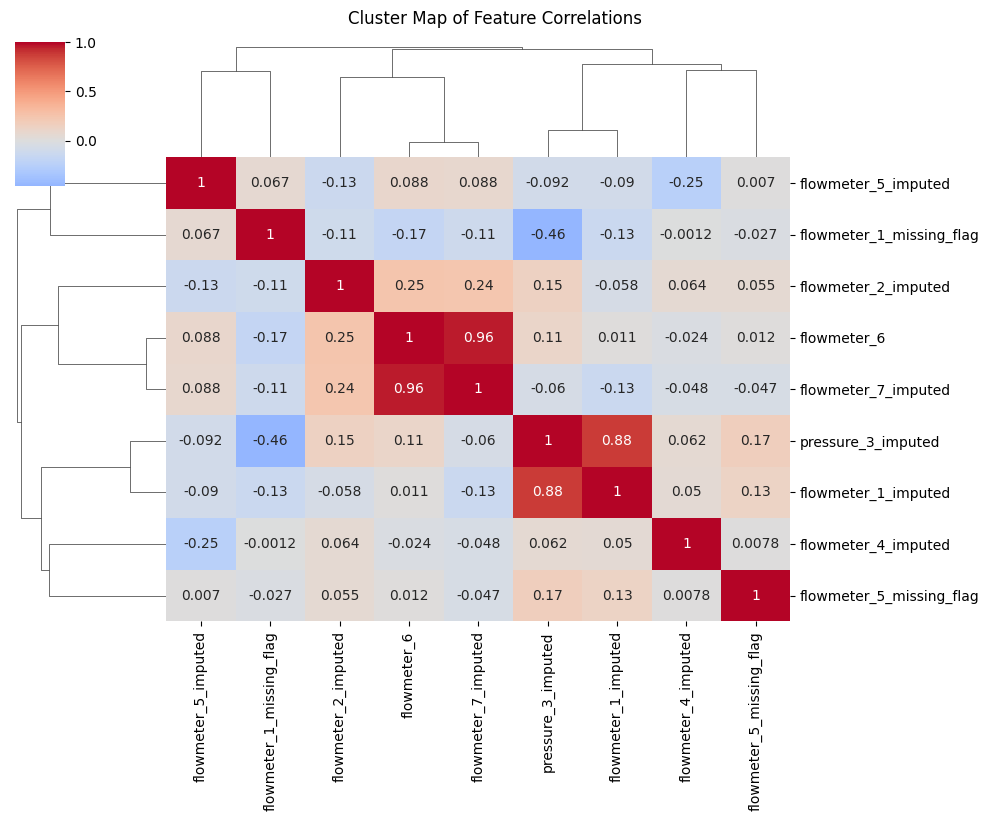

In [97]:
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 8), center=0)
plt.suptitle("Cluster Map of Feature Correlations", y=1.02)
plt.show()


In [98]:
# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_corr)

In [99]:
feature_names = df_corr.columns

In [100]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

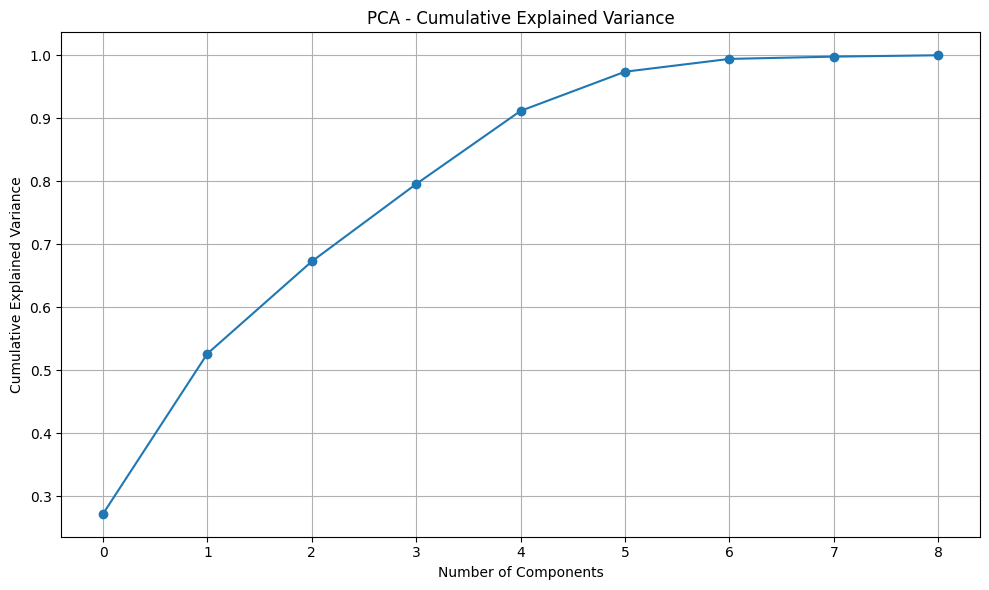

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [102]:
# Make a DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df_corr.columns))], index=feature_names)

# Top contributing features to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False))


                               PC1       PC2
flowmeter_5_imputed       0.660234  0.602536
flowmeter_6               0.499261 -0.439240
flowmeter_7_imputed       0.484315 -0.399571
flowmeter_2_imputed       0.115823 -0.450875
flowmeter_5_missing_flag -0.009346 -0.017579
flowmeter_1_missing_flag -0.010978  0.058789
pressure_3_imputed       -0.059807 -0.147389
flowmeter_1_imputed      -0.088280 -0.059461
flowmeter_4_imputed      -0.235105 -0.228142


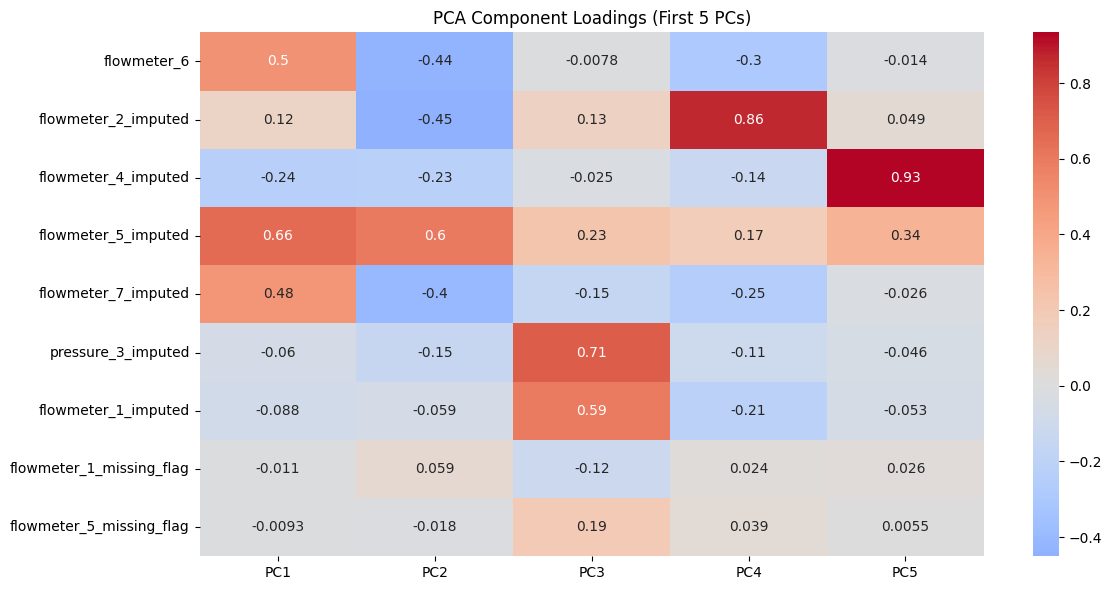

In [103]:
plt.figure(figsize=(12, 6))
sns.heatmap(loadings.iloc[:, :5], cmap='coolwarm', center=0, annot=True)
plt.title("PCA Component Loadings (First 5 PCs)")
plt.tight_layout()
plt.show()


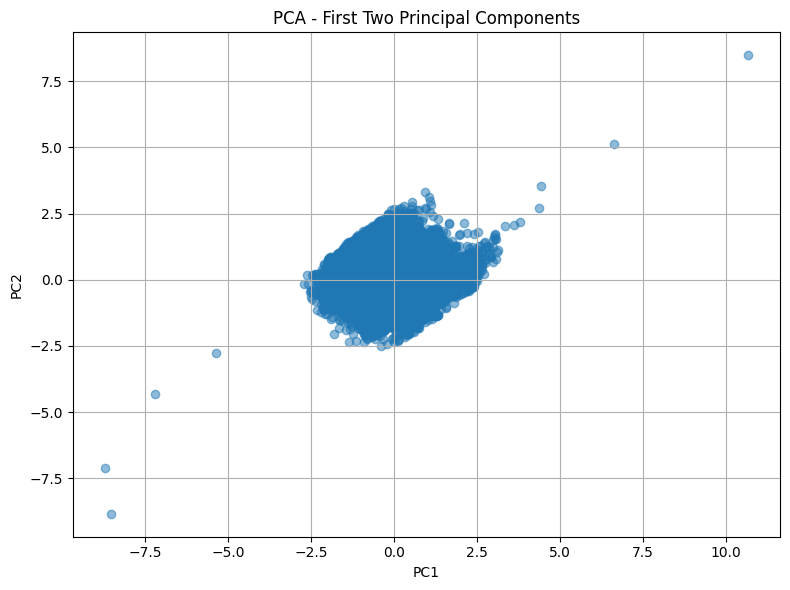

In [104]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - First Two Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()


In [105]:
df_updated.head()

,flowmeter_6,flowmeter_2_imputed,flowmeter_4_imputed,flowmeter_5_imputed,flowmeter_7_imputed,pressure_3_imputed,flowmeter_1_imputed,flowmeter_1_missing_flag,flowmeter_5_missing_flag
_id,,,,,,,,,
2025-03-01 00:00:00,3.090302,2.381213,1.789499,8.024493,2.3148,557.779602,29.154518,0,0
2025-03-01 00:10:00,3.109822,2.406482,1.815873,8.044760,2.3328,557.497742,28.985508,0,0
2025-03-01 00:20:00,3.128422,2.427540,1.840293,7.965942,2.3512,556.837219,29.180040,0,0
2025-03-01 00:30:00,3.144000,2.445229,1.864713,7.925407,2.3676,557.021484,29.205606,0,0
2025-03-01 00:40:00,3.161402,2.465444,1.890110,7.898383,2.3856,558.429871,29.325514,0,0


In [108]:
window_size = 24

# List of features
features = [
    'pressure_3',
    'flowmeter_6',
    'flowmeter_5_imputed',
    'flowmeter_1_imputed',
    'flowmeter_2_imputed',
    'flowmeter_4_imputed',
    'flowmeter_7_imputed'
]

# Create rolling mean and std features
for col in features:
    df_updated[f'{col}_roll_mean_4h'] = df[col].rolling(window=window_size, min_periods=24).mean()
    df_updated[f'{col}_roll_std_4h'] = df[col].rolling(window=window_size, min_periods=24).std()

/tmp/ipython-input-108-1248864449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated[f'{col}_roll_mean_4h'] = df[col].rolling(window=window_size, min_periods=24).mean()
/tmp/ipython-input-108-1248864449.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated[f'{col}_roll_std_4h'] = df[col].rolling(window=window_size, min_periods=24).std()
/tmp/ipython-input-108-1248864449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [109]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   flowmeter_6                       13248 non-null  float64
 1   flowmeter_2_imputed               13248 non-null  float64
 2   flowmeter_4_imputed               13248 non-null  float64
 3   flowmeter_5_imputed               13248 non-null  float64
 4   flowmeter_7_imputed               13248 non-null  float64
 5   pressure_3_imputed                13248 non-null  float64
 6   flowmeter_1_imputed               13248 non-null  float64
 7   flowmeter_1_missing_flag          13248 non-null  int64  
 8   flowmeter_5_missing_flag          13248 non-null  int64  
 9   pressure_3_roll_mean_4h           13201 non-null  float64
 10  pressure_3_roll_std_4h            13201 non-null  float64
 11  flowmeter_6_roll_mean_4h        

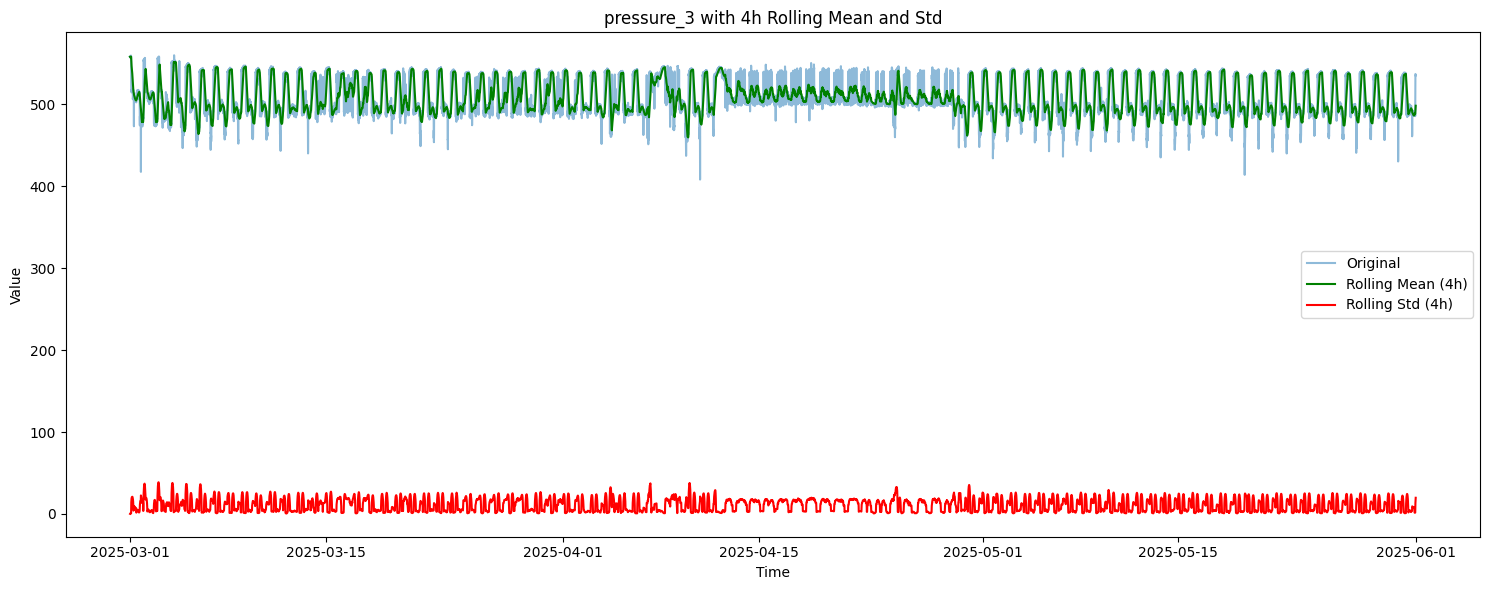

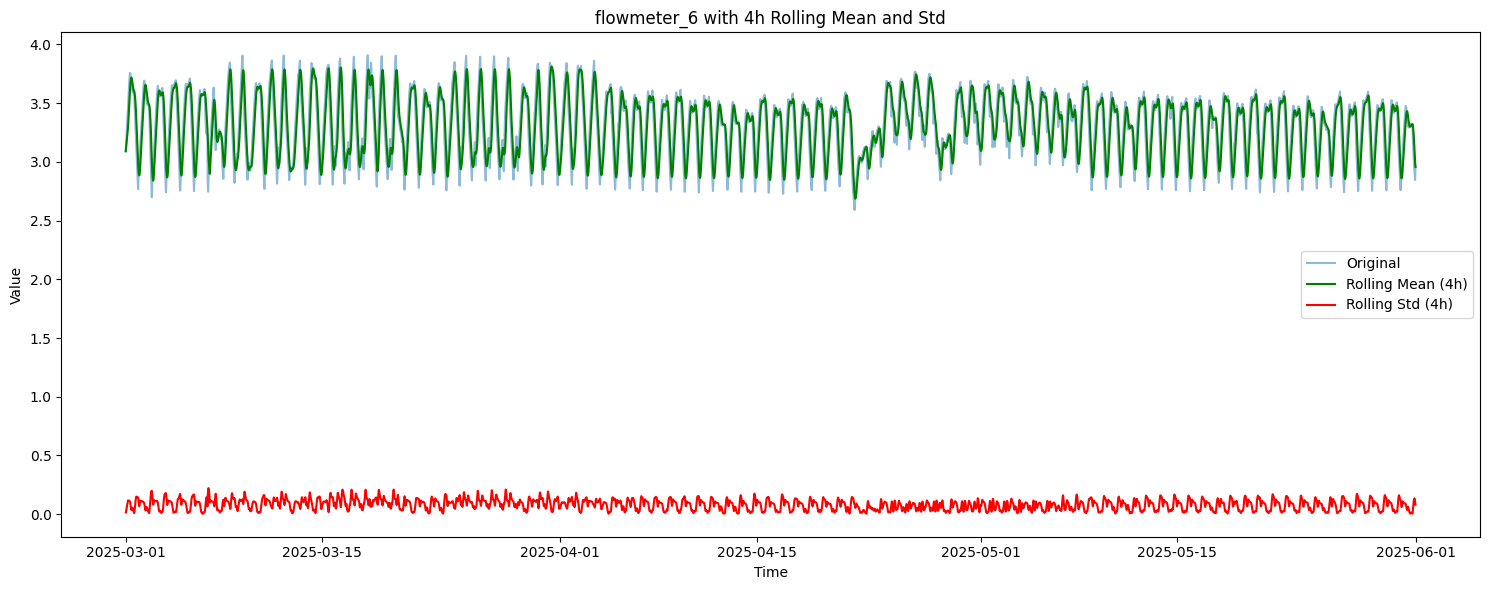

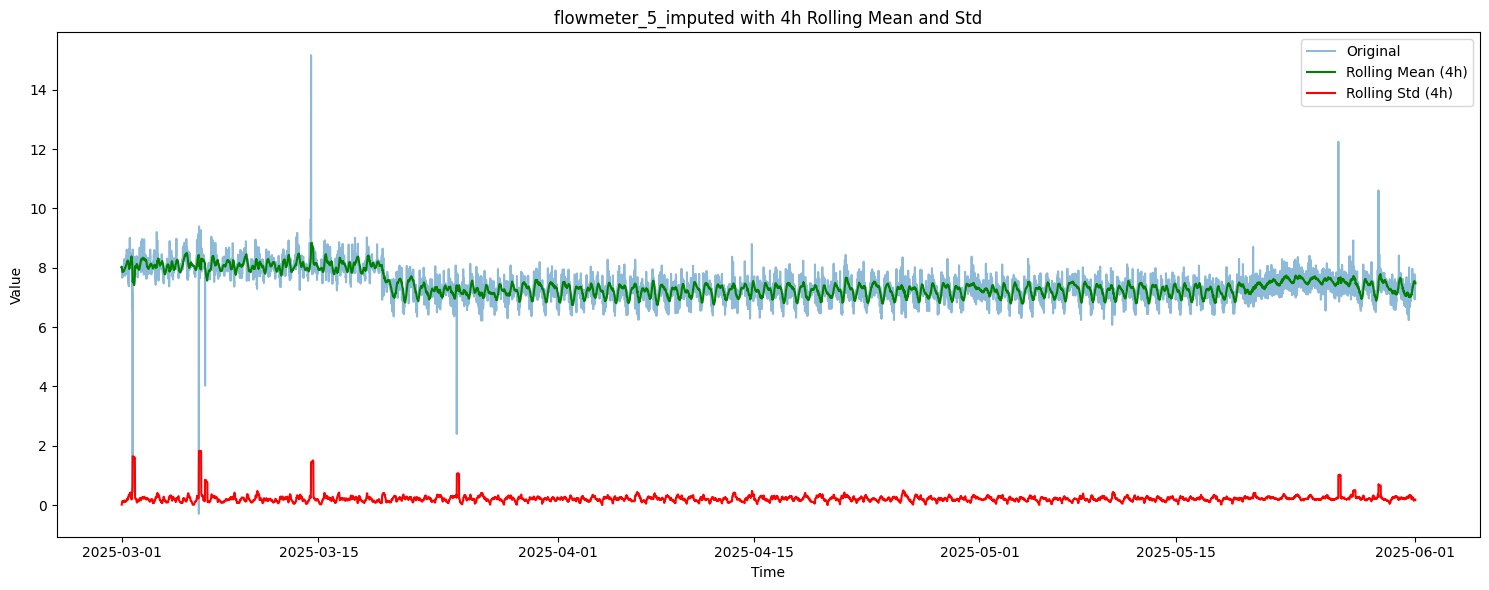

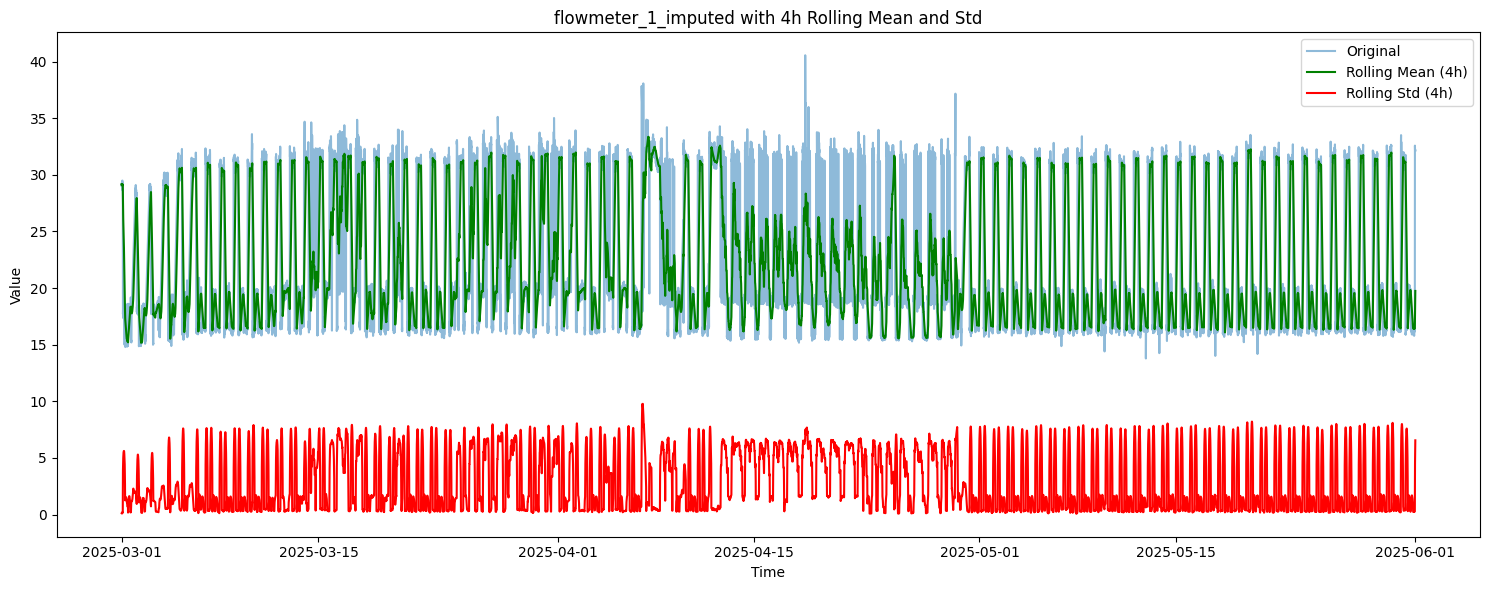

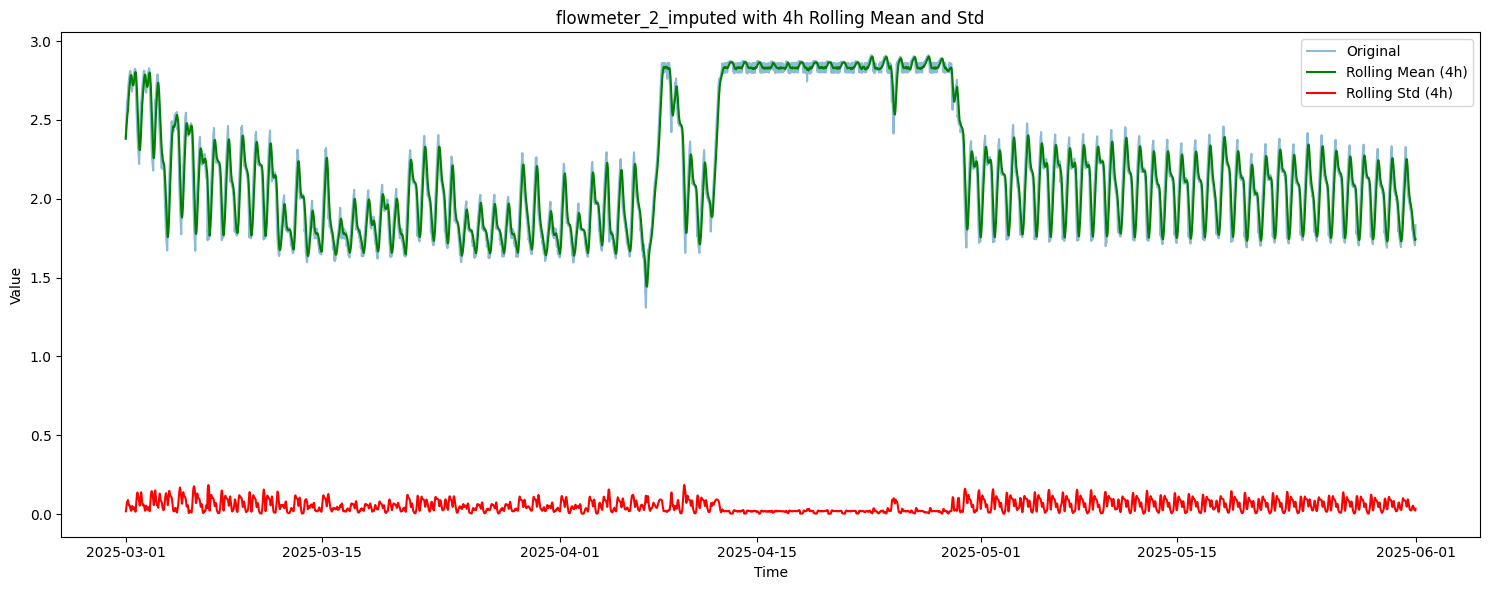

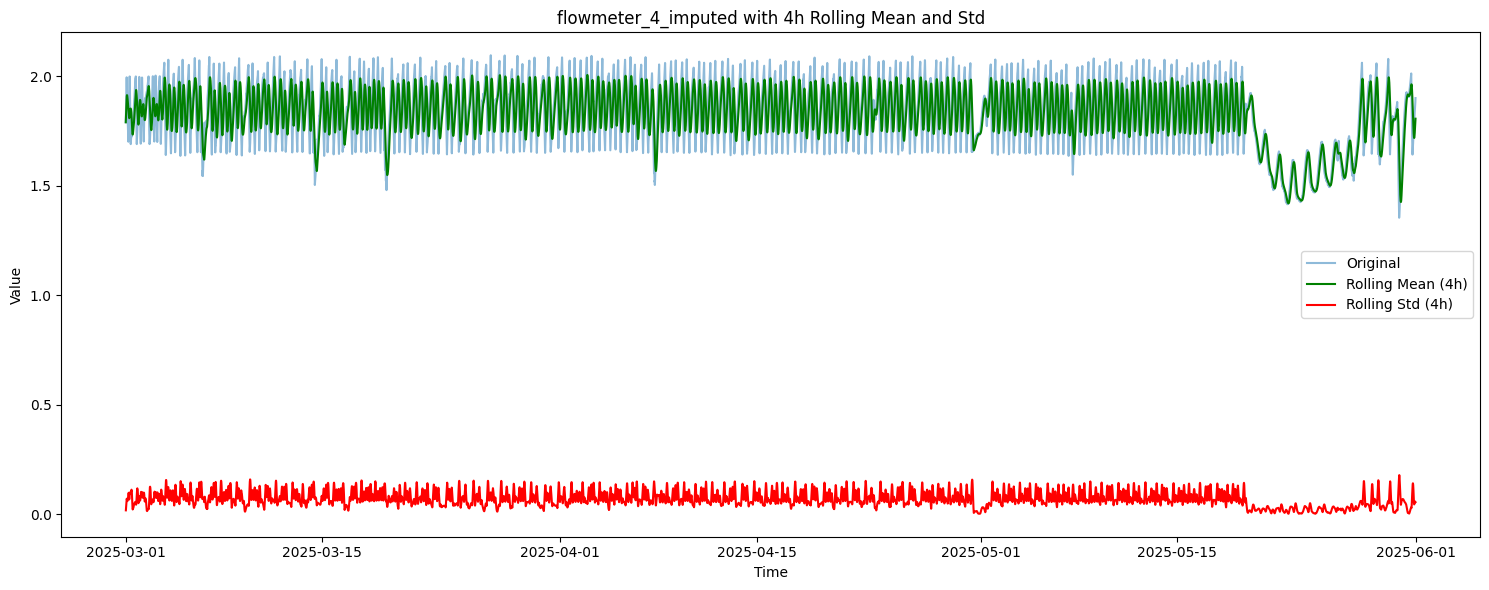

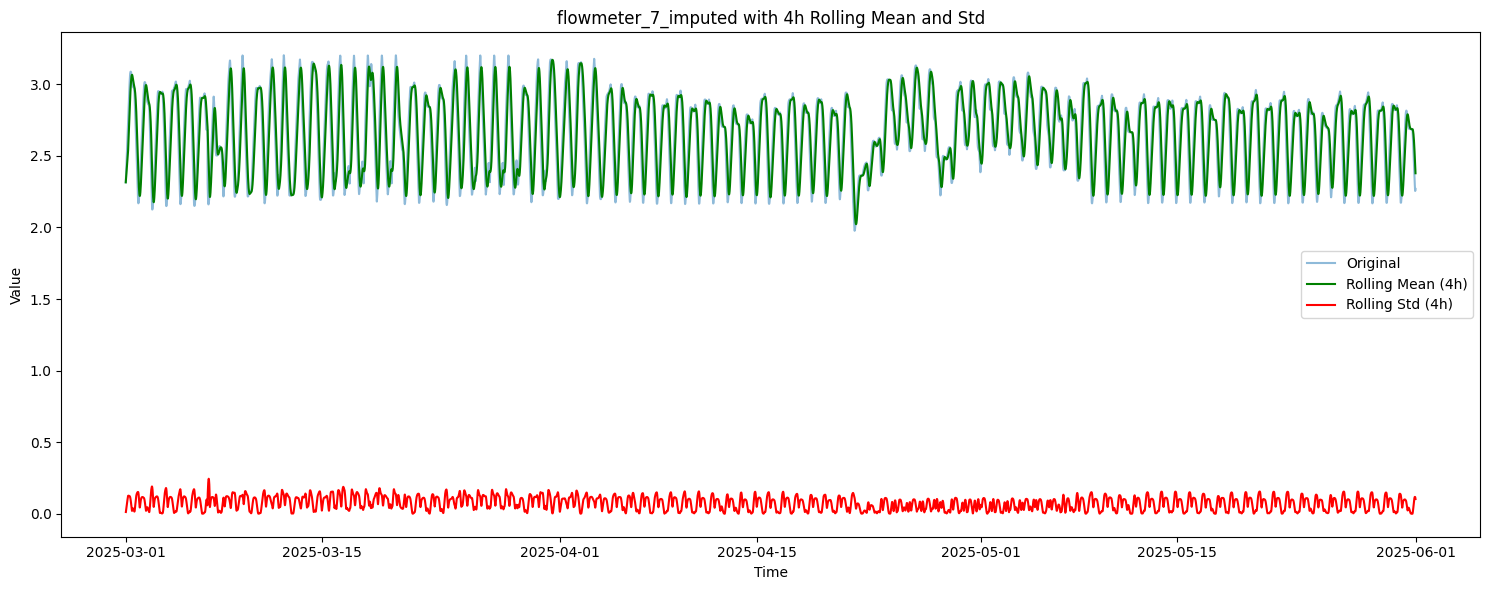

In [111]:
for feature in features:
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[feature], label='Original', alpha=0.5)
    plt.plot(df.index, df[f'{feature}_roll_mean_4h'], label='Rolling Mean (4h)', color='green')
    plt.plot(df.index, df[f'{feature}_roll_std_4h'], label='Rolling Std (4h)', color='red')
    plt.title(f'{feature} with 4h Rolling Mean and Std')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


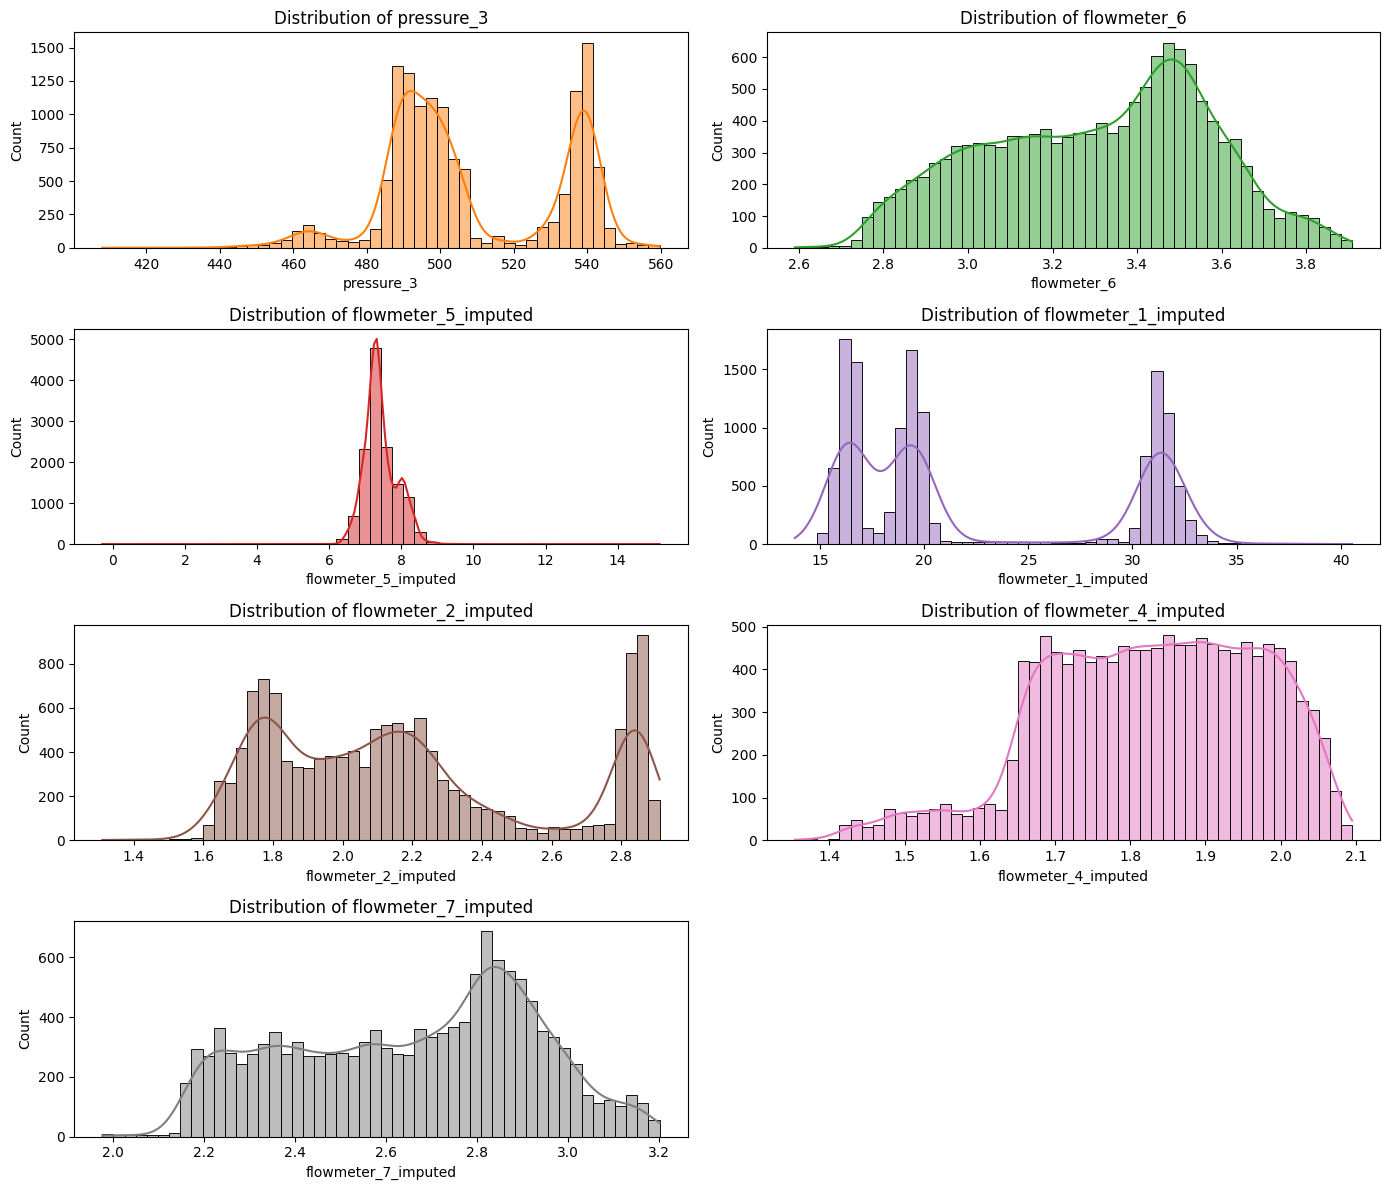

In [113]:

plt.figure(figsize=(14, 12))
for i, col in enumerate(features, start=1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, bins=50, color=f'C{i}')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [115]:
from sklearn.preprocessing import PowerTransformer

def apply_yeojohnson_transform(df, feature_cols):
    """
    Apply Yeo–Johnson transform to features that include zeros.
    - zero & positive values without shifting.
    - Stabilizes variance & reduces skew for robust anomaly detection.
    """
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    df_trans = df.copy()
    df_trans[feature_cols] = pt.fit_transform(df_trans[feature_cols])
    return df_trans

# Assumption: Some feature columns contain zero values; all others are ≥ 0.
feature_cols = [
    'flowmeter_6',
    'flowmeter_2_imputed',
    'flowmeter_4_imputed',
    'flowmeter_5_imputed',
    'flowmeter_7_imputed',
    'pressure_3_imputed',
    'flowmeter_1_imputed'
]

# Replace previous Box–Cox step with Yeo–Johnson
df_transformed = apply_yeojohnson_transform(df_updated, feature_cols)

# Next: proceed with robust median/MAD anomaly detection on `df_transformed` as before.


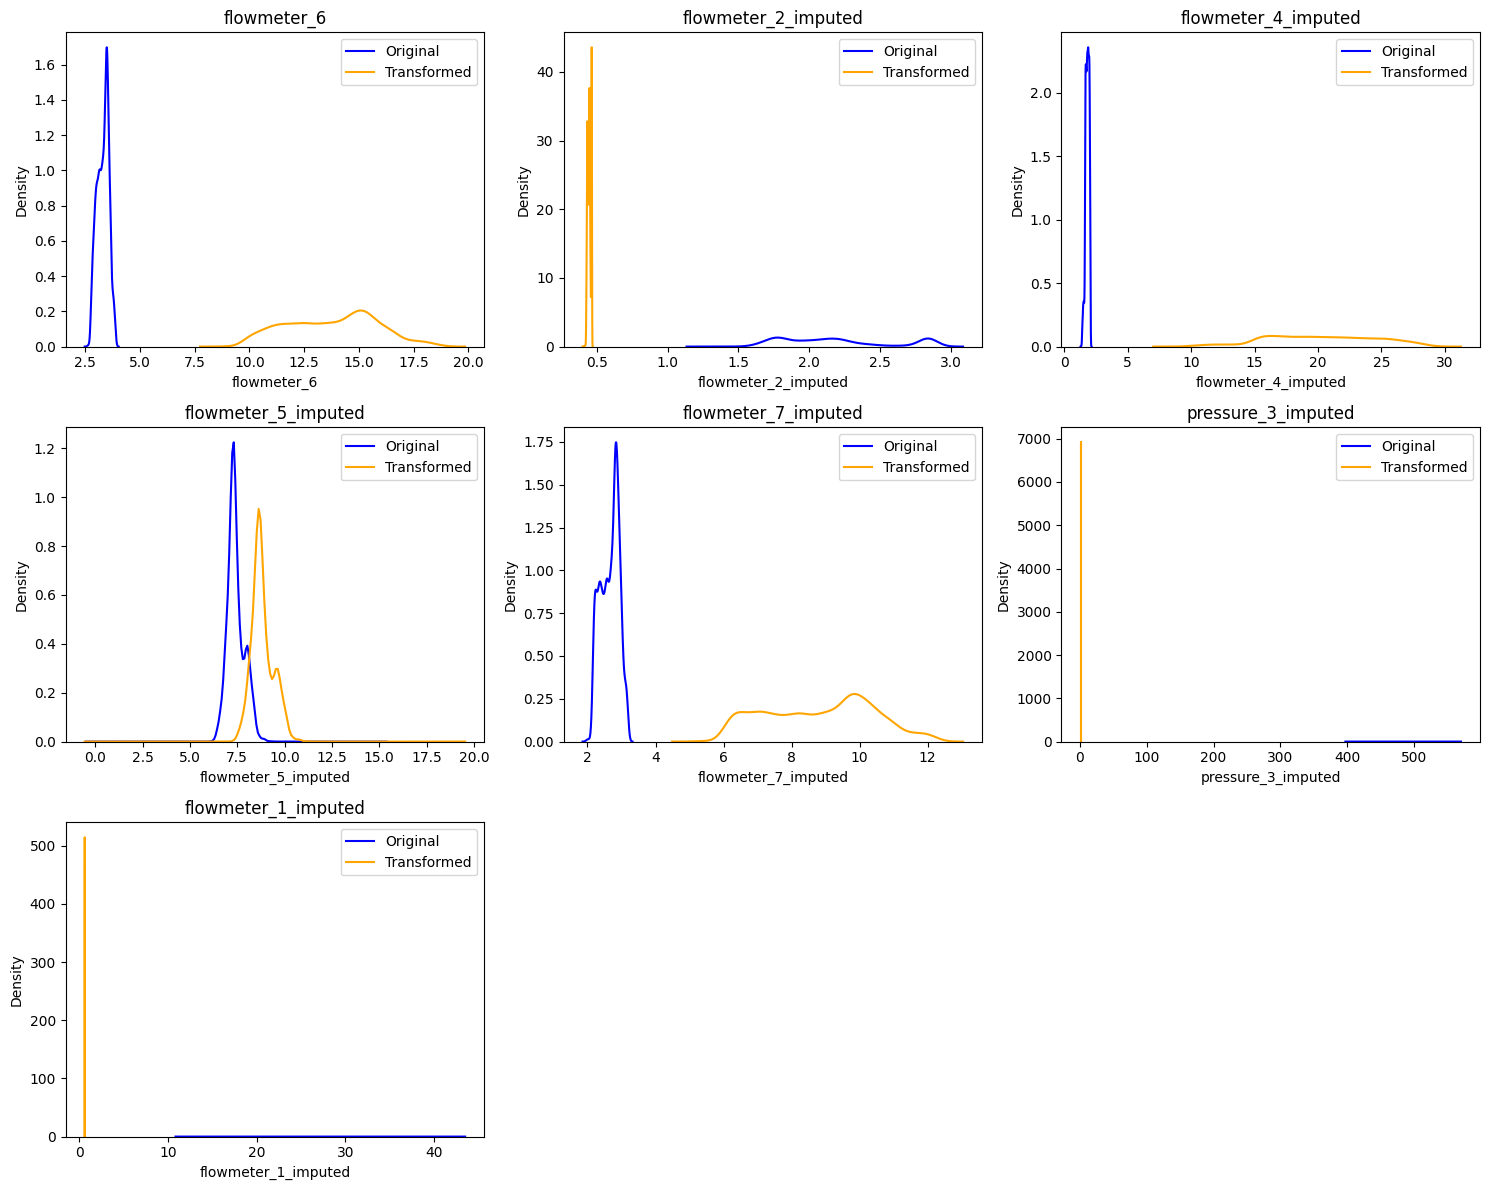

In [117]:

def plot_density_comparison(df_original, df_transformed, feature_cols, n_cols=3):
    """
    Plots side-by-side KDE plots for each feature, comparing original and transformed values.
    Args:
        df_original: pd.DataFrame, original untransformed data.
        df_transformed: pd.DataFrame, transformed data (Yeo–Johnson).
        feature_cols: list of feature names to plot.
        n_cols: how many plots per row (default 3).
    """
    n_features = len(feature_cols)
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(feature_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.kdeplot(df_original[col].dropna(), label='Original', color='blue')
        sns.kdeplot(df_transformed[col].dropna(), label='Transformed', color='orange')
        plt.title(col)
        plt.legend()
    plt.tight_layout()
    plt.show()


plot_density_comparison(df_updated, df_transformed, feature_cols)


In [137]:
# 1. Initialization: Prepare DataFrame for anomaly labeling
def initialize_labels(df):
    """
    Create new columns to store anomaly labels and metadata.
    - 'anomaly_type': 0=normal, 1=Type A (sustained), 2=Type B (spike)
    - 'anomaly_start'/'anomaly_end': timestamps marking anomaly periods
    - 'anomaly_severity': numeric score indicating magnitude
    """
    df = df.copy()  # Avoid modifying original
    df['anomaly_type']     = 0      # Default: normal
    df['anomaly_start']    = pd.NaT  # To record start of anomaly
    df['anomaly_end']      = pd.NaT  # To record end of anomaly
    df['anomaly_severity'] = np.nan  # To record calculated severity
    return df

df_updated = initialize_labels(df_updated)



In [138]:
def detect_type_b_robust(df, feature_cols, modz_thresh=2, q_low=0.01, q_high=0.99):
    """
    Identify single-point spikes/dips using:
      - Modified Z-score (median & MAD)
      - Empirical quantile (e.g., 0.5% and 99.5%)
    Returns a list of candidate points.
    """
    candidates = []
    for col in feature_cols:
        series = df[col].dropna()
        median = series.median()
        mad = np.median(np.abs(series - median))
        # Prevent division by zero if MAD is 0
        mad = mad if mad > 0 else np.std(series) or 1.0
        mod_z = 0.6745 * (series - median) / mad
        modz_mask = np.abs(mod_z) > modz_thresh

        # Empirical quantiles
        lower_q, upper_q = series.quantile([q_low, q_high])
        quant_mask = (series < lower_q) | (series > upper_q)
        mask = modz_mask | quant_mask

        for ts, val in series[mask].items():
            candidates.append({
                'type': 'B',
                'sensor': col,
                'timestamp': ts,
                'value': val,
                'severity': np.abs(mod_z.loc[ts])
            })
    return candidates

type_b_candidates = detect_type_b_robust(df_updated, feature_cols)


In [139]:
def compute_rolling_mad(df, cols, window=24):
    """
    Compute rolling MAD (median absolute deviation) for each feature.
    Returns a DataFrame with columns: 'feature_roll_mad_4h'
    """
    roll_mad = {}
    for col in cols:
        roll_mad[col + '_roll_mad_4h'] = df[col].rolling(window).apply(
            lambda x: np.median(np.abs(x - np.median(x))), raw=True
        )
    return pd.DataFrame(roll_mad, index=df.index)

def compute_rolling_median(df, cols, window=24):
    """Compute 4h rolling median for each feature."""
    roll_med = {}
    for col in cols:
        roll_med[col + '_roll_med_4h'] = df[col].rolling(window).median()
    return pd.DataFrame(roll_med, index=df.index)

# Compute rolling median and MAD
roll_mad_df = compute_rolling_mad(df_transformed, feature_cols)
roll_med_df = compute_rolling_median(df_transformed, feature_cols)

def detect_type_a_robust(df, feature_cols, roll_med_df, roll_mad_df,
                         dev_thresh=3.0, mad_thresh=3.0):
    """
    Flag intervals where rolling median deviates from global median or
    rolling MAD is unusually high, for at least 4 hours.
    """
    candidates = []
    for col in feature_cols:
        base = df[col]
        gmed = base.median()
        gmad = np.median(np.abs(base - gmed))
        rm_col = col + '_roll_med_4h'
        rmad_col = col + '_roll_mad_4h'
        roll_med = roll_med_df[rm_col]
        roll_mad = roll_mad_df[rmad_col]
        # Robust deviation and volatility flag
        flag = (
            (roll_med - gmed).abs() > dev_thresh * gmad
        ) | (roll_mad > mad_thresh * gmad)

        in_run, start_ts, prev_ts = False, None, None

        for ts, is_anom in flag.items():
            if is_anom and not in_run:
                in_run, start_ts = True, ts
            elif not is_anom and in_run:
                duration = prev_ts - start_ts
                if duration >= pd.Timedelta(hours=4):
                    candidates.append({
                        'type': 'A',
                        'sensor': col,
                        'start': start_ts,
                        'end': prev_ts,
                        'severity': float(
                            (roll_med.loc[start_ts:prev_ts] - gmed).abs().max() / gmad
                        )
                    })
                in_run = False
            prev_ts = ts
        if in_run and prev_ts - start_ts >= pd.Timedelta(hours=4):
            candidates.append({
                'type': 'A',
                'sensor': col,
                'start': start_ts,
                'end': prev_ts,
                'severity': float(
                    (roll_med.loc[start_ts:prev_ts] - gmed).abs().max() / gmad
                )
            })
    return candidates

type_a_candidates = detect_type_a_robust(
    df_updated, feature_cols, roll_med_df, roll_mad_df
)


In [140]:
# 1. View some samples of anomalies labeled in df_transformed
print("Sample anomalies in df_updated:")
print(df_updated[df_updated['anomaly_type'] > 0].head())

# 2. Frequency count of each anomaly type
anomaly_counts = df_updated['anomaly_type'].value_counts()

type_map = {0: 'Normal', 1: 'Type A - Sustained', 2: 'Type B - Spike'}

print("\nAnomaly counts by type:")
print(anomaly_counts.rename(index=type_map))

# 3. Count unique Type A events (interval anomalies)
unique_type_a_events = df_updated[df_updated['anomaly_type'] == 1]['anomaly_start'].nunique()
print(f"\nNumber of unique Type A anomaly intervals: {unique_type_a_events}")

# 4. Count unique Type B events (single timestamp spikes)
unique_type_b_events = df_updated[df_updated['anomaly_type'] == 2]['anomaly_start'].nunique()
print(f"Number of unique Type B anomaly points: {unique_type_b_events}")


Sample anomalies in df_updated:
Empty DataFrame
Columns: [flowmeter_6, flowmeter_2_imputed, flowmeter_4_imputed, flowmeter_5_imputed, flowmeter_7_imputed, pressure_3_imputed, flowmeter_1_imputed, flowmeter_1_missing_flag, flowmeter_5_missing_flag, pressure_3_roll_mean_4h, pressure_3_roll_std_4h, flowmeter_6_roll_mean_4h, flowmeter_6_roll_std_4h, flowmeter_5_imputed_roll_mean_4h, flowmeter_5_imputed_roll_std_4h, flowmeter_1_imputed_roll_mean_4h, flowmeter_1_imputed_roll_std_4h, flowmeter_2_imputed_roll_mean_4h, flowmeter_2_imputed_roll_std_4h, flowmeter_4_imputed_roll_mean_4h, flowmeter_4_imputed_roll_std_4h, flowmeter_7_imputed_roll_mean_4h, flowmeter_7_imputed_roll_std_4h, anomaly_type, anomaly_start, anomaly_end, anomaly_severity]
Index: []

[0 rows x 27 columns]

Anomaly counts by type:
anomaly_type
Normal    13248
Name: count, dtype: int64

Number of unique Type A anomaly intervals: 0
Number of unique Type B anomaly points: 0
